In [1]:
import os

In [2]:
os.getcwd()

'/home/llaszczuk/Documents/studia/magister/analiza_dyfuzji/ANDI-challenge'

In [3]:
import andi
import joblib
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dalex as dx
import sweetviz as sv

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

pd.options.plotting.backend = 'plotly'
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from configuration import RANDOM_STATE, CLASS_MAPPING

In [4]:
def custom_residual_function(model, X, y):
    probs = model.predict_proba(X)
    real_class_pred = probs.flatten()[[int(probs.shape[1]*i+val) for i, val in enumerate(y)]]
    return np.abs((1 - real_class_pred).astype('float64'))

def custom_predict(model, X):
    return model.predict_proba(X)

def custom_predict_normal(model, X):
    return model.predict(X)

def custom_predict_old(model, X):
    pred_class = np.argmax(model.predict_proba(X), axis=1)
    return pred_class.astype('float')

def loss_accuracy(y_real, y_pred):
    return 1 - accuracy_score(y_real, y_pred)

def loss_multiclass(y_real, y_proba):
    proba_real = np.array([el[y_real[i]] for i, el in enumerate(y_proba)])
    return np.mean(1 - proba_real)

def categorical_cross_entropy(y_real, y_proba):        
    return np.mean(-np.log(y_proba.flatten()[[int(y_proba.shape[1]*i+value) for i,value in enumerate(y_real)]]))



In [5]:
def save_image(image, image_path):
    image.write_image(image_path)

In [6]:
sklearn.__version__

'0.24.1'

In [7]:
# model = joblib.load('Models/model_patrycja_2d.sav')
model = joblib.load('Models/model_new.sav')

In [8]:
type(model)

sklearn.ensemble._gb.GradientBoostingClassifier

In [9]:
model.n_features_in_, model.feature_importances_

(43,
 array([0.00773765, 0.05132747, 0.01688546, 0.01355646, 0.01623142,
        0.03235592, 0.03166256, 0.02213367, 0.0102485 , 0.01245033,
        0.00894845, 0.02099241, 0.02665799, 0.03520371, 0.02443428,
        0.01278563, 0.0228737 , 0.03883725, 0.03943491, 0.04230392,
        0.01736131, 0.00780323, 0.01919932, 0.00336118, 0.00554859,
        0.0064468 , 0.01048522, 0.03716041, 0.04716106, 0.02016397,
        0.02022277, 0.04833661, 0.03746196, 0.01769155, 0.01725982,
        0.06021936, 0.05106566, 0.02240222, 0.01790037, 0.01120006,
        0.01996623, 0.00717681, 0.00734382]))

In [10]:
X = pd.read_csv('Data/characteristics/characteristics_new.csv', index_col=0)
X = X.drop(['file', 'Alpha'], axis=1)
y, X = X['motion'], X.drop(['motion'], axis=1)

In [11]:
X

D     alpha  alpha_n_1  alpha_n_2  alpha_n_3  fractal_dimension  \
0      0.435803  0.858277   0.936101   0.715941   0.694636           5.915085   
1      0.280414  0.840597   0.911857   1.108778   0.938683           4.845187   
2      0.963089  1.025218   1.137300   1.099772   1.029161           2.461289   
3      0.024340  0.517065   0.497310   0.402947   0.382388           3.528335   
4      0.026507  0.002433   0.076306   0.009666   0.000000           4.973644   
...         ...       ...        ...        ...        ...                ...   
63020  0.084406  0.959251   0.882007   0.978701   0.947940           3.025670   
63021  0.615047  0.404811   0.878974   0.341453   0.263552           2.039783   
63022  1.204477  1.396361   1.404331   1.491122   1.441684           4.319815   
63023  0.004430  0.815728   0.507113   0.703079   0.668713           2.150196   
63024  0.680747  1.192524   1.224230   1.276610   1.202104           4.549148   

       mean_gaussianity  mean_squared_displacement_ratio  straightness  \
0              0.516484                         0.004357      0.009712   
1              0.889044                         0.012224      0.042819   
2              2.872704                        -0.002190      0.088136   
3              1.656631                         0.019172      0.003352   
4              0.448400                         0.135507      0.007039   
...                 ...                              ...           ...   
63020          1.596120                         0.006292      0.034598   
63021         18.506112                         0.080027      0.129471   
63022          1.488684                        -0.019607      0.064704   
63023          8.210348                         0.012655      0.047765   
63024          0.737830                        -0.012444      0.029803   

       p-variation  ...  mw_x_std_10  mw_y_std_10  max_std_x  max_std_y  \
0              3.0  ...     0.364191     0.308240   3.424559   3.704983   
1              2.0  ...     0.385681     0.394919   3.143585   2.826468   
2              4.0  ...     0.351220     0.424390  14.808427   7.714073   
3              2.0  ...     0.431243     0.365237   4.795295   5.697282   
4              0.0  ...     0.455399     0.502347   2.917197   2.661875   
...            ...  ...          ...          ...        ...        ...   
63020          3.0  ...     0.444915     0.409605   7.232418   5.070652   
63021          2.0  ...     0.505051     0.444444  15.698080  13.667057   
63022          4.0  ...     0.245283     0.350943   1.954289   2.892623   
63023          3.0  ...     0.513605     0.515306  40.967889  12.859716   
63024          4.0  ...     0.316872     0.341564   3.863670   3.834457   

       max_std_change_x  max_std_change_y  vac_lag_1  vac_lag_2   dma_lag_1  \
0              0.261402          0.171022  -0.064121   0.025920  151.559399   
1              0.606814          0.315446  -0.234441  -0.007055   52.743428   
2              0.448157          0.401270   0.000802   0.136353  341.516986   
3              0.775568          0.575666  -0.350531  -0.010386    7.878370   
4              1.997836          1.396094  -0.498886  -0.031858    0.741571   
...                 ...               ...        ...        ...         ...   
63020          0.690987          0.265648  -0.236094  -0.027191   17.339402   
63021          1.698187          3.177987  -0.063220  -0.230472   27.951355   
63022          0.061771          0.118296  -0.136779   0.065074  279.335850   
63023          0.574738          1.433149  -0.283512  -0.018603    1.623039   
63024          0.094334          0.331938   0.061957   0.071792  407.830461   

        dma_lag_2  
0      151.711979  
1       52.862750  
2      342.062613  
3        7.886880  
4        0.743097  
...           ...  
63020   17.352289  
63021   27.757589  
63022  279.853130  
63023    1.625756  
63024  408.652293  

[63025 rows x 43 columns]

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

In [26]:
y_test.iloc[0]

2.0

In [27]:
feature_names = X.columns

## Plan:
1. Overall model performance, standard feature importance -- done
2. Permutation feature importance --> eli5, dalex -- done
3. SHAP feature importance;
4. Stratx;
5. Partial dependence profiles;

## 1. Overall model performance

In [28]:
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)

In [81]:
generated_data_hist = px.histogram(y)

In [25]:
generated_data_hist

In [21]:
save_image(generated_data_hist, os.path.join('Explanation', 'new', 'generated_data_hist.png'))

In [22]:
predicted_data_hist = px.histogram(y_pred)

In [18]:
save_image(predicted_data_hist, os.path.join('Explanation', 'new', 'predicted_data_hist.png'))

NameError: name 'predicted_data_hist' is not defined

In [29]:
confusion_matrix(y_test, y_pred)

array([[2223,  539,  181,   12,  843],
       [ 163, 3579,   34,    3,   10],
       [  82,   41, 3066,   76,  527],
       [  10,    1,   54, 3653,   32],
       [ 283,   12,  288,   14, 3182]])

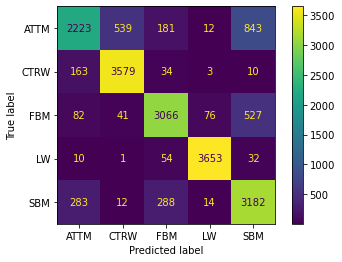

In [30]:
confusion_matrix_ = plot_confusion_matrix(model, x_test, y_test, display_labels=CLASS_MAPPING.values())

In [31]:
confusion_matrix_.figure_.savefig(os.path.join('Explanation', 'new', 'confusion_matrix.png'))
confusion_matrix_.figure_.savefig(os.path.join('Explanation', 'new', 'confusion_matrix.pdf'))

In [32]:
COMMON_ERRORS = {'True': ['ATTM', 'ATTM', 'FBM', 'SBM'],
                 'Predict': ['CTRW', 'SBM', 'CTRW', 'ATTM']}

In [33]:
# Most common errors
pd.DataFrame(COMMON_ERRORS)

True Predict
0  ATTM    CTRW
1  ATTM     SBM
2   FBM    CTRW
3   SBM    ATTM

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.59      0.68      3798
         1.0       0.86      0.94      0.90      3789
         2.0       0.85      0.81      0.83      3792
         3.0       0.97      0.97      0.97      3750
         4.0       0.69      0.84      0.76      3779

    accuracy                           0.83     18908
   macro avg       0.83      0.83      0.83     18908
weighted avg       0.83      0.83      0.83     18908



## 2. Permutation feature importance with eli5

In [35]:
import eli5
from eli5.sklearn import PermutationImportance

In [36]:
model.feature_importances_

array([0.00773765, 0.05132747, 0.01688546, 0.01355646, 0.01623142,
       0.03235592, 0.03166256, 0.02213367, 0.0102485 , 0.01245033,
       0.00894845, 0.02099241, 0.02665799, 0.03520371, 0.02443428,
       0.01278563, 0.0228737 , 0.03883725, 0.03943491, 0.04230392,
       0.01736131, 0.00780323, 0.01919932, 0.00336118, 0.00554859,
       0.0064468 , 0.01048522, 0.03716041, 0.04716106, 0.02016397,
       0.02022277, 0.04833661, 0.03746196, 0.01769155, 0.01725982,
       0.06021936, 0.05106566, 0.02240222, 0.01790037, 0.01120006,
       0.01996623, 0.00717681, 0.00734382])

In [37]:
feature_names

Index(['D', 'alpha', 'alpha_n_1', 'alpha_n_2', 'alpha_n_3',
       'fractal_dimension', 'mean_gaussianity',
       'mean_squared_displacement_ratio', 'straightness', 'p-variation',
       'max_excursion_normalised', 'ksstat_chi2', 'p_var_1', 'p_var_2',
       'p_var_3', 'p_var_4', 'p_var_5', 'dagostino_x', 'dagostino_y', 'M', 'L',
       'J', 'max_ts', 'trappedness', 'asymmetry', 'diff_kurtosis',
       'efficiency', 'mw_x_mean', 'mw_y_mean', 'mw_x_std', 'mw_y_std',
       'mw_x_mean_10', 'mw_y_mean_10', 'mw_x_std_10', 'mw_y_std_10',
       'max_std_x', 'max_std_y', 'max_std_change_x', 'max_std_change_y',
       'vac_lag_1', 'vac_lag_2', 'dma_lag_1', 'dma_lag_2'],
      dtype='object')

In [38]:
fi = pd.Series(index=feature_names, data=model.feature_importances_).sort_values()

In [39]:
standard_fi_plot = px.bar(fi, orientation='h', height=1200, width=1000)

In [40]:
standard_fi_plot

In [41]:
save_image(standard_fi_plot, os.path.join('Explanation', 'new', 'standard_fi.png'))

### Basic permutation feature importance with eli5

In [34]:
perm = PermutationImportance(model).fit(x_test, y_test)

In [36]:
permutation_fi = eli5.show_weights(perm, feature_names=list(feature_names))

In [47]:
with open(os.path.join('Explanation', 'new','eli5-pfi.html'), 'w') as f:
    f.write(permutation_fi.data)


### Dalex explainer

In [42]:
explainer_proba = dx.Explainer(model, x_test, y_test, predict_function=custom_predict, residual_function=custom_residual_function)
explainer_normal = dx.Explainer(model, x_test, y_test, predict_function=custom_predict_normal, residual_function=custom_residual_function)

Preparation of a new explainer is initiated

  -> data              : 18908 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 18908 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x7f4b109c1d40> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.49e-08, mean = 0.2, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>


/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 1e-07, mean = 0.188, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 18908 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 18908 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f4b109cc0e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.17, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>
  -> residuals         : min = 1e-07, mean = 0.188, max = 1.0
  -> model_info        : package sklearn

A new expl

In [43]:
pfi = explainer_proba.model_parts(loss_function=categorical_cross_entropy)

In [44]:
pfi_categorical_cross_entropy = pfi.plot(max_vars=44, show=False)

In [45]:
pfi_categorical_cross_entropy

In [46]:
save_image(pfi_categorical_cross_entropy, os.path.join('Explanation', 'new', 'pfi-logloss.png'))

### Categorical cross entropy loss function

In [47]:
pfi_categorical_cross_entropy

In [48]:
pfi_accuracy = explainer_normal.model_parts(loss_function=loss_accuracy)

In [49]:
pfi_accuracy_plot = pfi_accuracy.plot(max_vars=44, show=False)

In [50]:
save_image(pfi_accuracy_plot, os.path.join('Explanation', 'new', 'pfi-accuracy.png'))

### Accuracy loss function

In [51]:
pfi_accuracy_plot

### PFI per class

In [52]:
x_test['y'] = y_test
for i in range(5):    
    x_sub = x_test[x_test['y'] == i]
    y_sub, x_sub = x_sub['y'], x_sub.drop('y', axis=1)
    print(y_sub)
    
    explainer_sub = dx.Explainer(model, x_sub, y_sub, predict_function=custom_predict, residual_function=custom_residual_function)    
    pfi = explainer_sub.model_parts(loss_function=categorical_cross_entropy)
    pfi_plot = pfi.plot(max_vars=44, show=False)
    save_image(pfi_plot, os.path.join('Explanation', 'new', 'class_pfi', f"pfi-logloss-{CLASS_MAPPING[str(i)]}.pdf"))
    
    explainer_normal = dx.Explainer(model, x_sub, y_sub, predict_function=custom_predict_normal, residual_function=custom_residual_function)
    pfi = explainer_normal.model_parts(loss_function=loss_accuracy)
    pfi_plot = pfi.plot(max_vars=44, show=False)
    save_image(pfi_plot, os.path.join('Explanation', 'new', 'class_pfi', f"pfi-acc-{CLASS_MAPPING[str(i)]}.pdf"))

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



51975    0.0
8446     0.0
15428    0.0
39916    0.0
4608     0.0
        ... 
55454    0.0
62113    0.0
20846    0.0
34447    0.0
31400    0.0
Name: y, Length: 3798, dtype: float64
Preparation of a new explainer is initiated

  -> data              : 3798 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3798 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x7f4b109c1d40> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.66e-07, mean = 0.2, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>


/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 1.34e-05, mean = 0.412, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 3798 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3798 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f4b109cc0e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 1.13, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>
  -> residuals         : min = 1.34e-05, mean = 0.412, max = 1.0
  -> model_info        : package sklearn

A new 

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 9e-07, mean = 0.0758, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 3789 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3789 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f4b109cc0e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.975, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>
  -> residuals         : min = 9e-07, mean = 0.0758, max = 1.0
  -> model_info        : package sklearn

A new exp

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 1.57e-07, mean = 0.201, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 3792 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3792 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f4b109cc0e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.24, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>
  -> residuals         : min = 1.57e-07, mean = 0.201, max = 1.0
  -> model_info        : package sklearn

A new 

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 1e-07, mean = 0.0312, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 3750 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3750 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f4b109cc0e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.99, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>
  -> residuals         : min = 1e-07, mean = 0.0312, max = 1.0
  -> model_info        : package sklearn

A new expl

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 9.17e-06, mean = 0.218, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 3779 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3779 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f4b109cc0e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 3.53, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f4b109c6170>
  -> residuals         : min = 9.17e-06, mean = 0.218, max = 1.0
  -> model_info        : package sklearn

A new 

## 3. SHAP

In [53]:
import shap

In [54]:
EXPLAIN_OBSERVATION_NO = 1000

In [55]:
x_test_drop = x_test.drop('y', axis=1)

In [56]:
def generate_shap_values(model, x, i):
    med = x.median().values.reshape((1, x.shape[1]))
    shap_model = shap.KernelExplainer(model.predict_proba, med)
    shap_values = shap_model.shap_values(x.iloc[:i, :])
    return shap_model, shap_values

In [57]:
shap_values = generate_shap_values(model, x_test_drop, EXPLAIN_OBSERVATION_NO)

In [58]:
shap_model, shap_coefs = shap_values[0], shap_values[1]

In [59]:
base_value = shap_model.expected_value

In [ ]:
# sprawdzić rozkład fractal dimension w podziale na klasy

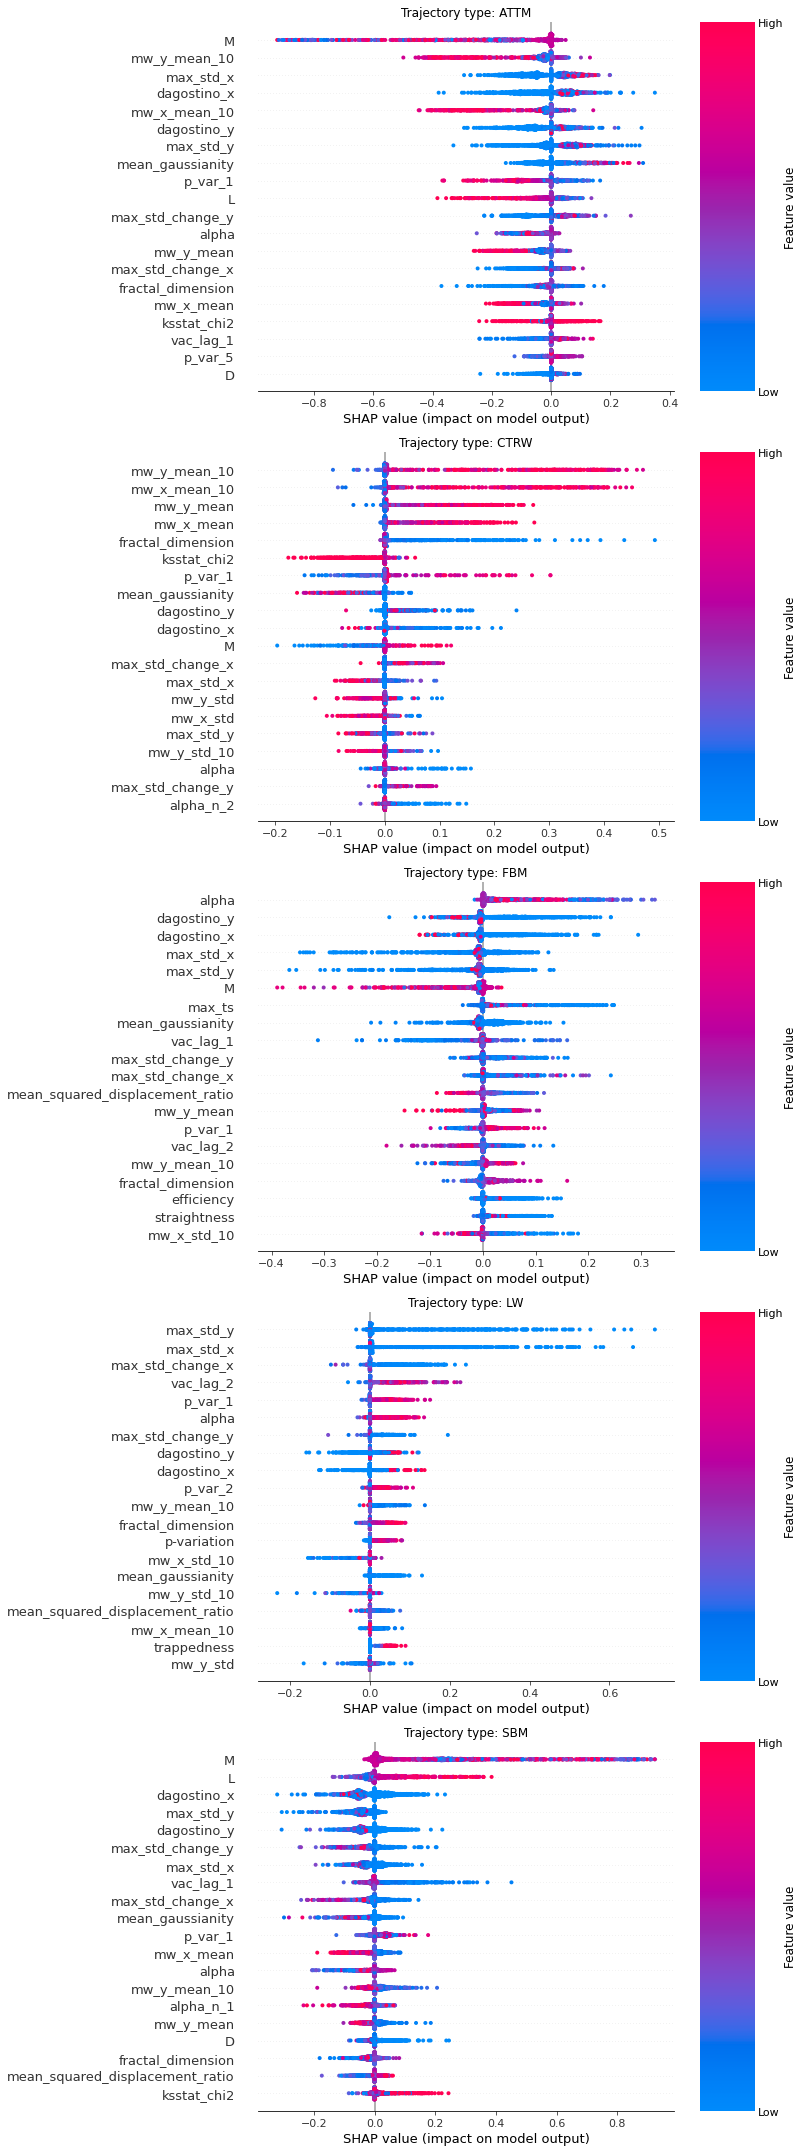

In [61]:
fig, axs = plt.subplots(5, 1)
for i in range(5):
    plt.sca(axs[i])
    shap.summary_plot(shap_coefs[i], x_test_drop.values[:EXPLAIN_OBSERVATION_NO, :], x_test_drop.columns, plot_type='dot', show=False)
    plt.gca().set_title(f"Trajectory type: {CLASS_MAPPING[str(int(model.classes_[i]))]}")
fig.set_size_inches(11, 30)
fig.tight_layout()
plt.savefig(os.path.join('Explanation', 'new', 'SHAP', 'SHAP-dot.pdf'), dpi=500)

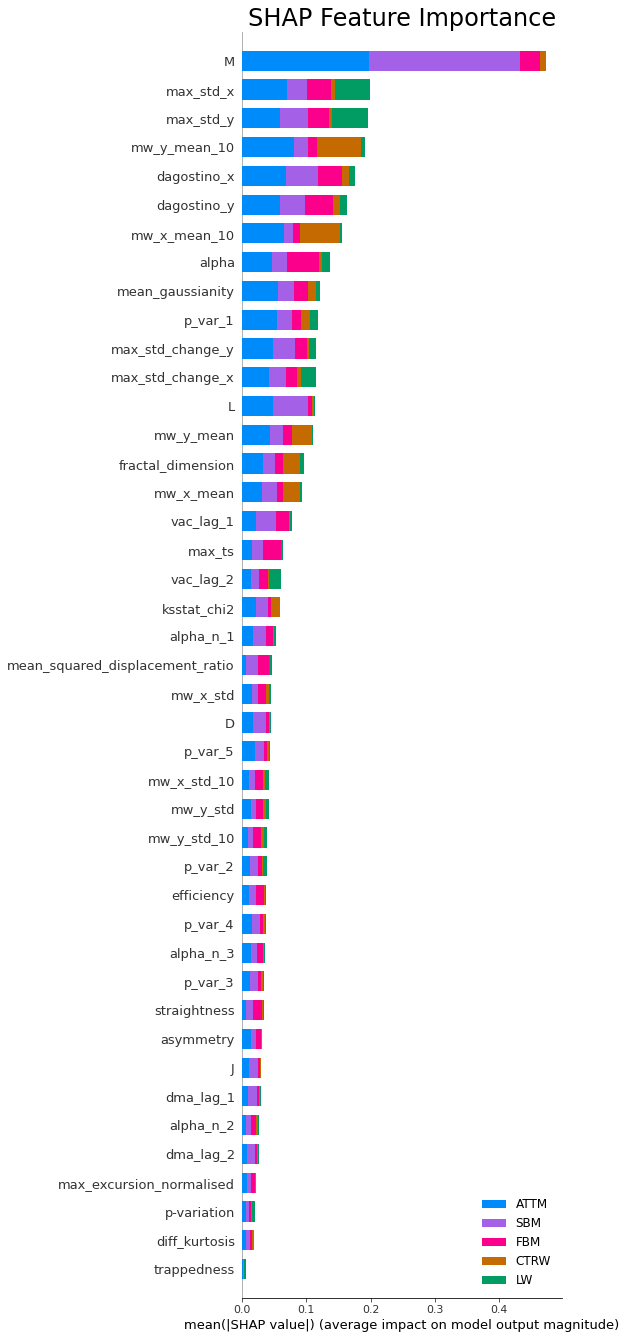

In [65]:
plt.figure()
shap.summary_plot(shap_coefs, x_test_drop.columns, plot_type='bar', class_names=list(CLASS_MAPPING.values()), show=False, max_display=50)
plt.title('SHAP Feature Importance', size=24)
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.savefig(os.path.join('Explanation', 'new', 'SHAP', 'SHAP-FI-all.pdf'), dpi=500)
plt.show()

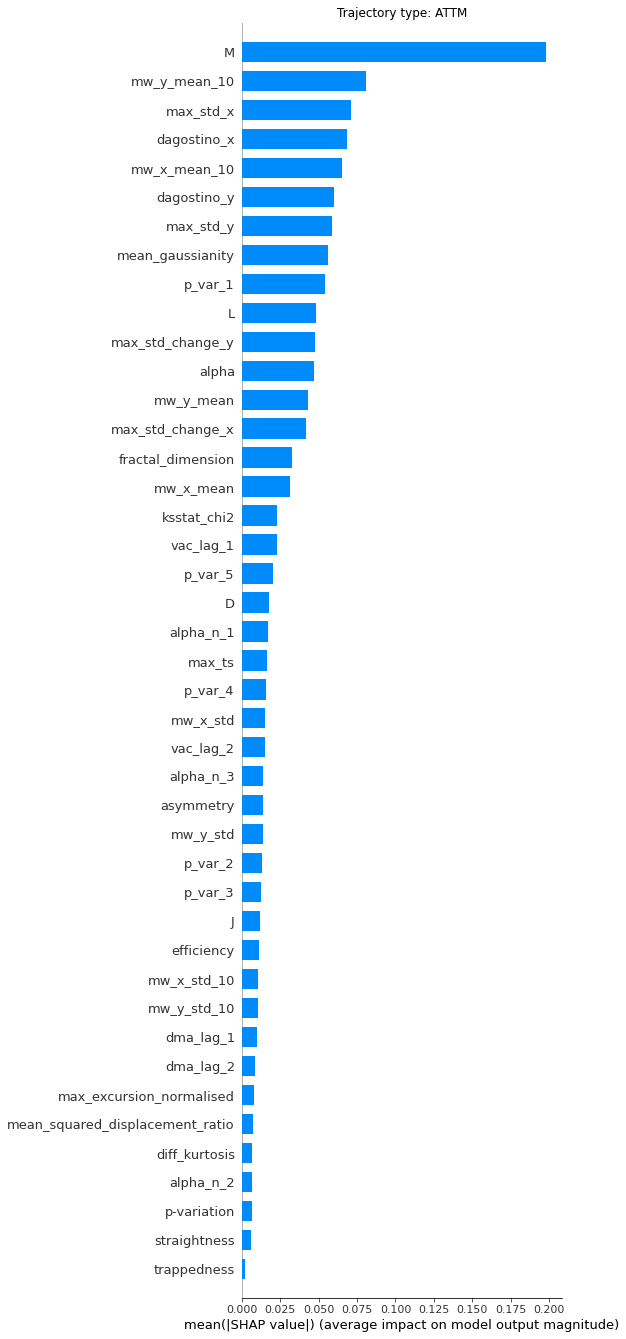

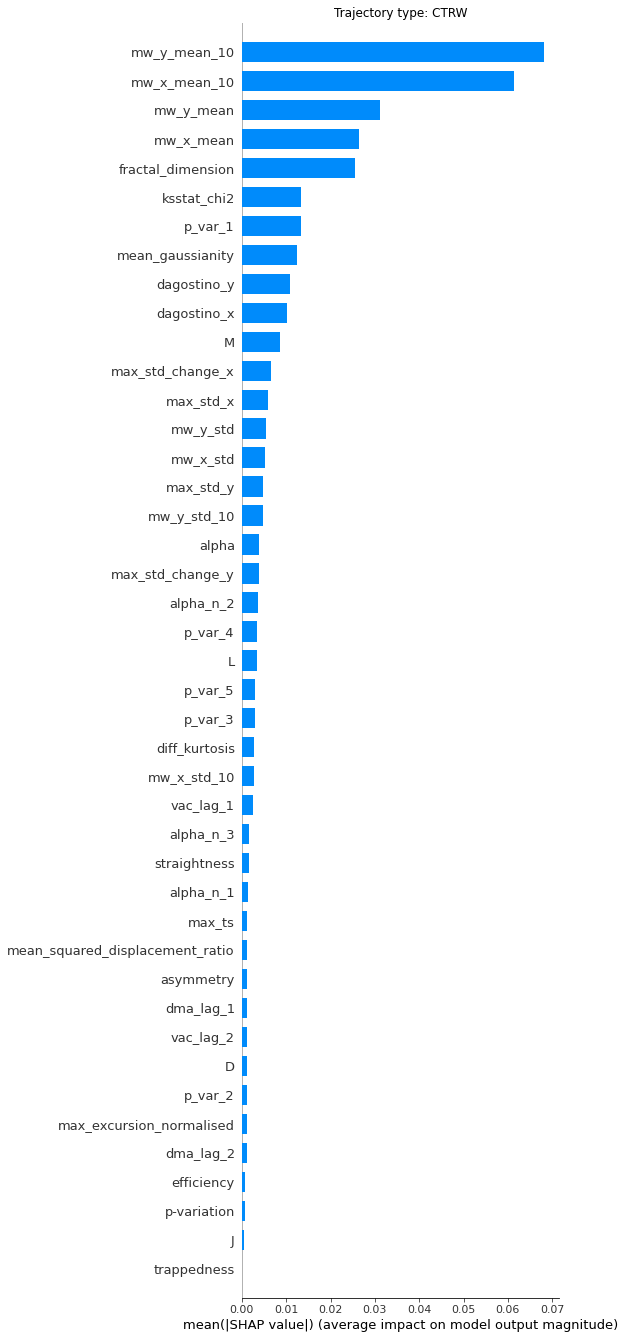

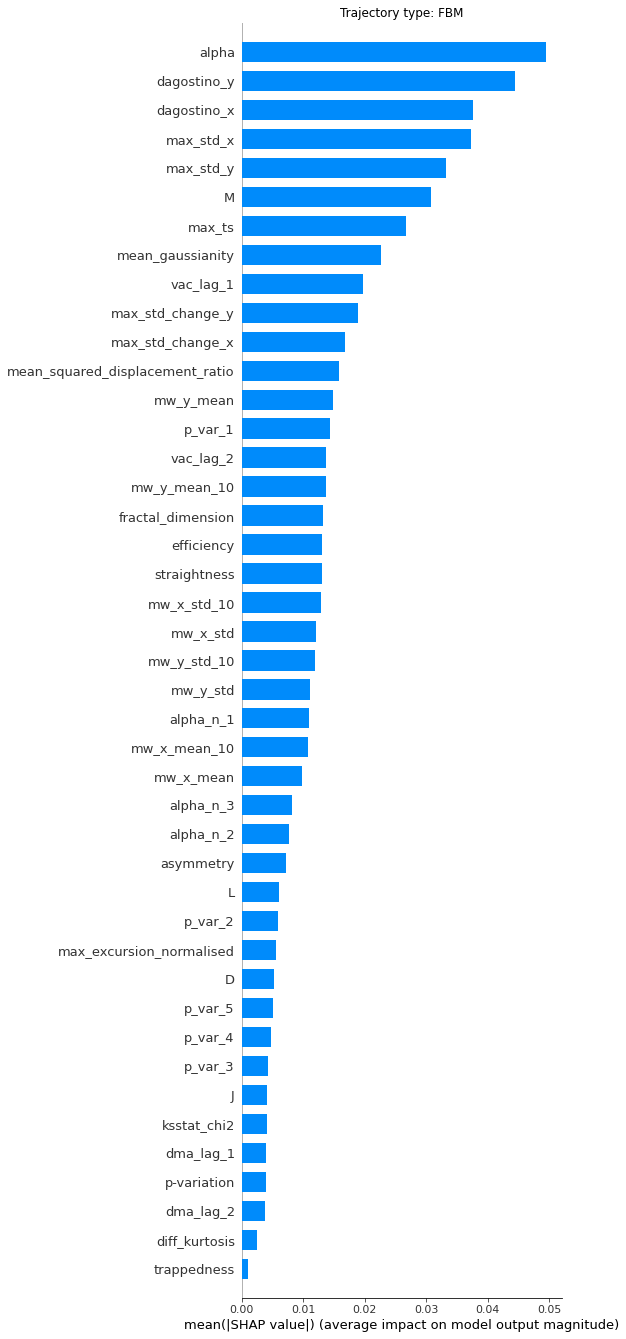

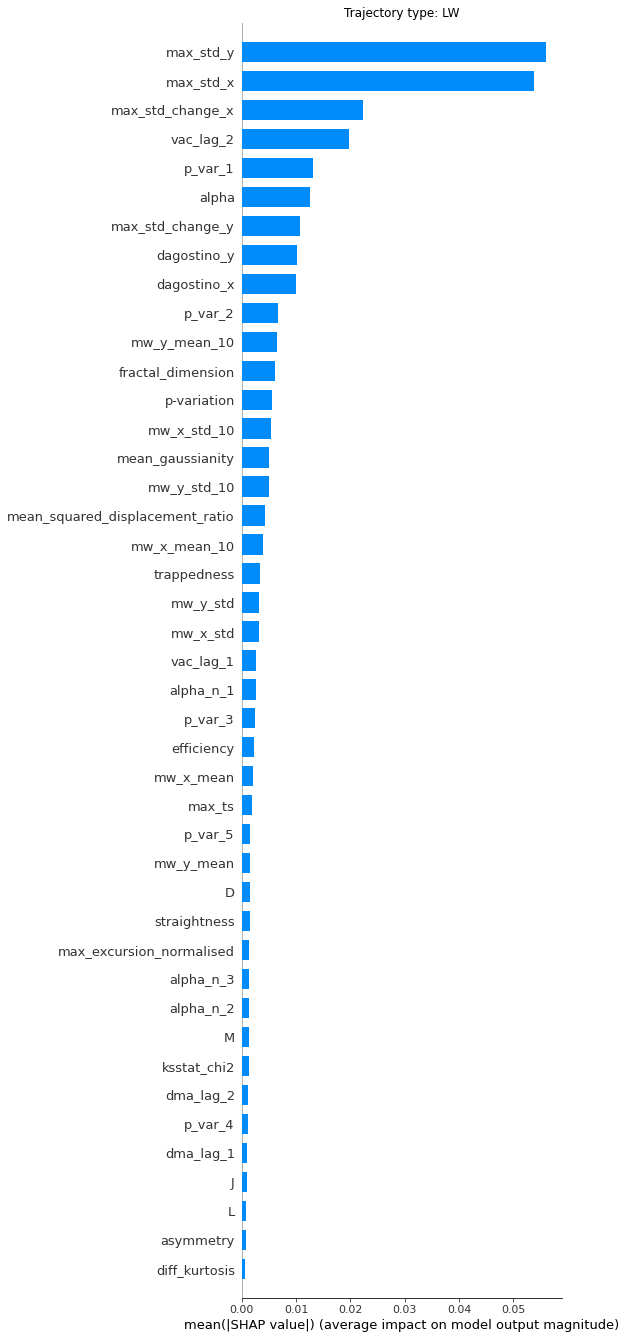

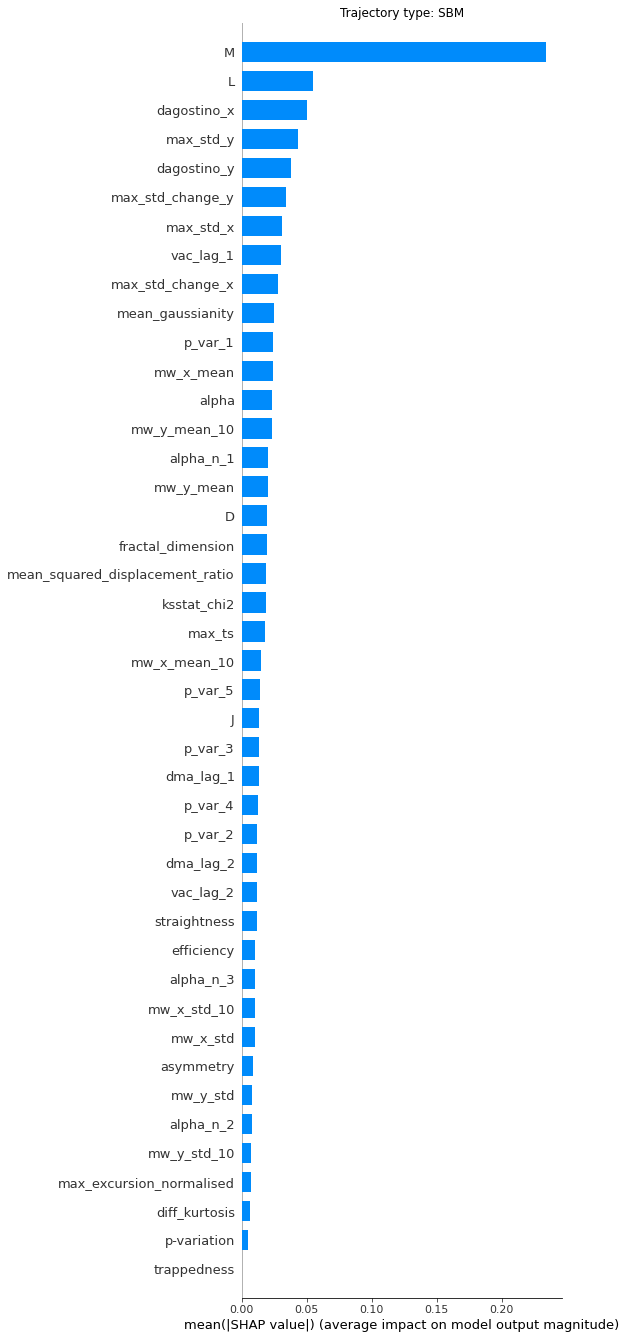

In [73]:
for i in range(5):
#     plt.figure(figsize=(20, 20))
    shap.summary_plot(shap_coefs[i], x_test_drop.columns, plot_type='bar', show=False, max_display=50)
    plt.title(f"Trajectory type: {CLASS_MAPPING[str(int(model.classes_[i]))]}")
    plt.tight_layout()
    plt.savefig(os.path.join('Explanation', 'new', 'SHAP', f'{CLASS_MAPPING[str(int(model.classes_[i]))]}.pdf'), dpi=400)
    plt.show()

## Create report for chosen observation from the most common mistakes trajectory types

1. BD plot;
2. Variable values vs overall distribution;
3. Ceteris paribus
4. PDP

In [75]:
COMMON_ERRORS = {'True': ['ATTM', 'ATTM', 'FBM'],
                 'Predict': ['CTRW', 'SBM', 'SBM']}

In [78]:
X = pd.read_csv('Data/characteristics/characteristics_new.csv', index_col=0)
X = X.drop(['file', 'Alpha'], axis=1)
X['motion'] = X['motion'].astype(int).astype(str).replace(CLASS_MAPPING)

In [88]:
bd_values = pd.read_csv(os.path.join('Data', 'break-down-values-new-model.csv'), index_col=0)

In [89]:
bd_values.iloc[:, -2:] = bd_values.iloc[:, -2:].astype(int).astype(str).replace(CLASS_MAPPING)

In [91]:
def create_observation_vs_distribution(X, observation_bd, class_real, class_pred):
    fig = make_subplots(rows=len(X.columns)-1, cols=1, subplot_titles=list(X.columns[1:]))
    for j, i in enumerate(list(X.columns[1:])):
        X_real = X[X['motion']==class_real]
        X_pred = X[X['motion']==class_pred]
        
        cur_fig = go.Figure()
        cur_fig.add_trace(go.Histogram(x=X_real.loc[:, i],
                                      histnorm='probability density',
                                      name=class_real,                                       
                                      legendgroup=class_real,
                                       showlegend=False if j>0 else True,
                                       marker={'color': 'red'}
                                      ))
        cur_fig.add_trace(go.Histogram(x=X_pred.loc[:, i],
                                      
                                       histnorm='probability density',
                                      name=class_pred,
                                       showlegend=False if j>0 else True,
                                      legendgroup=class_pred,
                                       marker={'color': 'blue'}))
        cur_fig.update_traces(opacity=0.2)
        cur_fig.add_trace(go.Scatter(x=[observation_bd[f'variable_value_{i}']], y=[0],
                                     name='value',
                                     showlegend=False,
                            marker={'color': 'black',
                                   'size':10}))
        cur_fig.update_layout(barmode='overlay')
        
        
        scatter = px.scatter()
        

        fig.add_trace(cur_fig.data[0], row=j+1, col=1)
        fig.add_trace(cur_fig.data[1], row=j+1, col=1)
        fig.add_trace(cur_fig.data[2], row=j+1, col=1)
        fig.update_layout(cur_fig.layout)
        
    fig.update_layout(width=1000, height=6000)
    return fig

In [93]:
for el in list(zip(COMMON_ERRORS['True'], COMMON_ERRORS['Predict'])):
    X_sub = X[(X['motion']==el[0])|(X['motion']==el[1])]
    bd_values_sub = bd_values[(bd_values['real_class']==el[0])&(bd_values['predicted_class']==el[1])].reset_index(drop=True)
    for i, obs in bd_values_sub.iterrows():
        if i<10:
            fig = create_observation_vs_distribution(X, obs, el[0], el[1])
            fig.write_image(os.path.join('Explanation', 'new', 'local', 'observation_vs_variable_distribution', f'{el[0]}_{el[1]}', f'{i+1}.pdf'))


## Creating report with results

In [94]:
import PyPDF2

In [95]:
def create_local_report(files_in, fileout):
    readers = []
    for file in files_in:
        readers.append(PyPDF2.PdfFileReader(open(file, 'rb')))
#     pdf1File = open(file1, 'rb')
#     pdf2File = open(file2, 'rb')

    # Read the files that you have opened
#     pdf1Reader = PyPDF2.PdfFileReader(pdf1File)
#     pdf2Reader = PyPDF2.PdfFileReader(pdf2File)

    # Create a new PdfFileWriter object which represents a blank PDF document
    pdfWriter = PyPDF2.PdfFileWriter()
    
    for reader in readers:
    # Loop through all the pagenumbers for the first document
        for pageNum in range(reader.numPages):
            pageObj = reader.getPage(pageNum)
            pdfWriter.addPage(pageObj)

    # Now that you have copied all the pages in both the documents, write them into the a new document
    pdfOutputFile = open(fileout, 'wb')
    pdfWriter.write(pdfOutputFile)

    # Close all the files - Created as well as opened
    pdfOutputFile.close()
#     for reader in readers:
#         reader.close()

In [98]:
top_variables = ['M', 'mw_x_mean_10','mw_y_mean_10',
                          'max_std_x', 'max_std_y', 'L', 'dagostino_x',
                          'mw_y_mean', 'mean_gaussianity', 'ksstat_chi2', 'p_var_1']
# top_vars = ['D','alpha','alpha_n_1','alpha_n_2','alpha_n_3','fractal_dimension','mean_gaussianity','mean_squared_displacement_ratio','straightness','p-variation','max_excursion_normalised','vac_lag_1','p_var_1','p_var_2','p_var_3','p_var_4','p_var_5']
for el in list(zip(COMMON_ERRORS['True'], COMMON_ERRORS['Predict'])):
    for i in range(2, 10):
        create_local_report([os.path.join('Explanation', 'new', 'local', 'break_down', f'{el[0]}_{el[1]}', f'{i}.pdf'),
                           os.path.join('Explanation', 'new', 'local', 'observation_vs_variable_distribution', f'{el[0]}_{el[1]}', f'{i}.pdf')]+\
                            [os.path.join('Explanation', 'new', 'local', 'ceteris_paribus', f'{el[0]}_{el[1]}', variable, f'{i}.pdf') for variable in top_variables]+\
                            [os.path.join('Explanation', 'new', 'local', 'partial_dependency', f'{el[0]}_{el[1]}',  f'{variable}.pdf') for variable in top_variables],
                           os.path.join('Explanation', 'new', 'local', 'reports', f'{el[0]}_{el[1]}', f'{i}.pdf'))
    